# Notebook Goals:

* Normalize death count data to town population (turn raw counts into deaths per 10k residents values)
* Pull out some ACS demographics data - correlation with death data?
* EDA on ACS demographics data, some feature engineering on poverty, population, and other demographics data

# Output:
* /data/tidy_data/death_count_norm_to_pop_and_acs_town_demographics_merge.csv

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
death_data = pd.read_csv("../../data/tidy_data/ma_town_opioid_overdose_death_by_place_of_death_2012_to_2018_merge.csv")
town_block_match = pd.read_csv("../../data/tidy_data/census_block_town_match.csv")
acs_17 = pd.read_csv("../../data/raw_data/R12288202_SL150.csv")

In [3]:
death_data.head()

,city_death,2012,2013,2014,2015,2016,2017,2018
0,abington,1,2,0,6,1,3,5
1,acton,2,0,1,2,3,0,1
2,acushnet,2,0,0,4,2,4,0
3,adams,1,1,2,3,1,0,4
4,agawam,1,3,1,2,0,4,8


In [4]:
display(town_block_match.head())
# remove extra column
town_block_match.drop('Unnamed: 0', axis=1, inplace=True)

,Unnamed: 0,TOWN,POP2010,SHAPE_Area,GEOID10,SHAPE_AREA,POP100_RE
0,0,wellesley,27982,2.726958e+07,2.502140e+11,6.424854e+05,935.0
1,0,wellesley,27982,2.726958e+07,2.502140e+11,1.167837e+06,989.0
2,0,wellesley,27982,2.726958e+07,2.502140e+11,1.182595e+06,968.0
3,0,wellesley,27982,2.726958e+07,2.502140e+11,1.079832e+06,1145.0
4,0,wellesley,27982,2.726958e+07,2.502140e+11,5.306549e+05,664.0


In [5]:
# town mismatch between death count data and the town-census block 
print(set(death_data['city_death']) - set(town_block_match['TOWN']))
print(set(town_block_match['TOWN']) - set(death_data['city_death']))
death_data['city_death'] = death_data['city_death'].str.replace('north attleboro', 'north attleborough')

{'north attleboro'}
{'north attleborough'}


In [6]:
# grab relevant columns from match file
town_block = town_block_match[['TOWN', 'POP2010', 'SHAPE_Area', 'GEOID10']].copy()

In [7]:
print(acs_17.shape)
acs_17.columns

(4985, 2200)


Index(['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US',
       ...
       'SE_A10065_001', 'SE_A10065_002', 'SE_A10066_001', 'SE_A10066_002',
       'SE_A10066_003', 'SE_A10066_004', 'SE_A10066_005', 'SE_A10066_006',
       'SE_A10066_007', 'SE_A10066_008'],
      dtype='object', length=2200)

In [8]:
# which columns to match on?
acs_17[['Geo_FIPS', 'Geo_GEOID']].head()
# Geo_FIPS is match for GEOID10 from town - block match df

,Geo_FIPS,Geo_GEOID
0,250010101001,15000US250010101001
1,250010101002,15000US250010101002
2,250010101003,15000US250010101003
3,250010101004,15000US250010101004
4,250010101005,15000US250010101005


In [9]:
# mismatches between sets?
print(len(set(acs_17['Geo_FIPS']) - set(town_block['GEOID10'])))
print(len(set(town_block['GEOID10']) - set(acs_17['Geo_FIPS'])))

31
4


### Potentially interesting columns to pull from ACS:
* A00002_001:   Total Population
* A00002_002:   Population Density (Per Sq. Mile)
* A12003_001:   Civilian Population 16 to 19 Years:
* A12003_002:      Not High School Graduate, Not Enrolled (Dropped Out)
* A12003_003:      High School Graduate, or Enrolled (In School)
* A12002_001:   Population 25 Years and Over:
* A12002_002:      Less than High School
* A14006_001:   Median Household Income (In 2017 Inflation Adjusted Dollars)
* A14008_001:   Average Household Income 
* NA- all missing - A14028_001:   Gini Index 
* NA - all missing - A17004_001:     Total Employed Civilian Population 16 Years and Over
* NA - all missing - A17004_002:     Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining
* NA - all missing - A17004_003:     Employed Civilian Population 16 Years and Over: Construction
* A01001_011:      65 to 74 Years
* A01001_012:      75 to 84 Years
* A01001_013:      85 Years and Over
* NA- all missing - A13003A_001:   Population Under 18 Years of Age for Whom Poverty Status Is Determined:
    * NA- all missing - A13003A_002:      Living in Poverty
    * NA- all missing - A13003A_003:      At or Above Poverty Level
* NA- all missing -A13003B_001:   Population Age 18 to 64 for Whom Poverty Status  Is Determined:
    * NA- all missing - A13003B_002:      Living in Poverty
    * NA- all missing - A13003B_003:      At or Above Poverty Level
* NA- all missing -A13003C_001:   Population Age 65 and Over for Whom Poverty  Status Is Determined:
    * NA- all missing -A13003C_002:      Living in Poverty
    * NA- all missing -A13003C_003:      At or Above Poverty Level
    
* B13004_001:     Population for Whom Poverty Status Is Determined:
    * B13004_002:     Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly)
    * B13004_003:     Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling)
    * B13004_004:     Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling)
    * B13004_005:     Population for Whom Poverty Status Is Determined: 2.00 and Over (Doing Ok)
* A13004_001:     Population for Whom Poverty Status Is Determined:    
    * A13004_002:     Population for Whom Poverty Status Is Determined: Under .50
    * NA- all missing - A13004_003:     Population for Whom Poverty Status Is Determined: .50 to .74
    * NA- all missing - A13004_004:     Population for Whom Poverty Status Is Determined: .75 to .99
    * A13004_005:     Population for Whom Poverty Status Is Determined: 1.00 to 1.49
    * A13004_006:     Population for Whom Poverty Status Is Determined: 1.50 to 1.99
    * A13004_007:     Population for Whom Poverty Status Is Determined: 2.00 and Over

In [10]:
acs_17_sub = acs_17[['Geo_FIPS', 'SE_A00002_001', 'SE_A00002_002',
     'SE_A12003_001', 'SE_A12003_002',
    'SE_A12002_001', 'SE_A12002_002', 'SE_A14006_001',
     'SE_A14008_001',
    # age 65+ cols:
     'SE_A01001_011', 'SE_A01001_012', 'SE_A01001_012',
    # poverty summarized:
    'SE_B13004_001', 'SE_B13004_002', 'SE_B13004_003', 'SE_B13004_004', 'SE_B13004_005'
    # poverty raw?:
    #'SE_A13004_001', 'SE_A13004_002', 'SE_A13004_003', 'SE_A13004_004', 'SE_A13004_005', 'SE_A13004_006', 'SE_A13004_007'
]].copy()

In [11]:
acs_17_sub.head()

,Geo_FIPS,SE_A00002_001,SE_A00002_002,SE_A12003_001,SE_A12003_002,SE_A12002_001,SE_A12002_002,SE_A14006_001,SE_A14008_001,SE_A01001_011,SE_A01001_012,SE_A01001_012,SE_B13004_001,SE_B13004_002,SE_B13004_003,SE_B13004_004,SE_B13004_005
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323,172,51,51,998,122,271,393,605
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913,107,43,43,314,55,36,91,223
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111,133,82,82,741,59,81,140,601
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623,46,78,78,500,46,206,252,248
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828,62,15,15,390,32,59,91,299


In [12]:
# readable names:
acs_17_sub.columns = [
    'GEOID10', 'tot_pop_17', 'pop_density',
    'civ_pop_16_19', 'civ_pop_16_19_drop',
    'pop_over_25', 'pop_over_25_less_school',
    'med_house_inc', 'mean_house_inc',
    'age_65_to_74', 'age_75_to_84', 'age_85_over',
    'pop_det_poverty', 'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug', 'pop_doing_ok'
]

In [13]:
acs_17_sub.head()

,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,age_65_to_74,age_75_to_84,age_85_over,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323,172,51,51,998,122,271,393,605
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913,107,43,43,314,55,36,91,223
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111,133,82,82,741,59,81,140,601
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623,46,78,78,500,46,206,252,248
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828,62,15,15,390,32,59,91,299


In [14]:
acs_17_sub['mean_med_inc_desp'] = acs_17_sub['mean_house_inc'] - acs_17_sub['med_house_inc']
acs_17_sub.head()

,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,age_65_to_74,age_75_to_84,age_85_over,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,mean_med_inc_desp
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323,172,51,51,998,122,271,393,605,23198.664323
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913,107,43,43,314,55,36,91,223,27372.419913
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111,133,82,82,741,59,81,140,601,26316.854111
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623,46,78,78,500,46,206,252,248,15977.442623
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828,62,15,15,390,32,59,91,299,18165.344828


In [15]:
# calculate num and prop of residents 
acs_17_sub['over_65_count'] = acs_17_sub['age_65_to_74'] + acs_17_sub['age_75_to_84'] + acs_17_sub['age_85_over']
acs_17_sub.drop(['age_65_to_74', 'age_75_to_84', 'age_85_over'], axis = 1, inplace=True)
acs_17_sub.head()

,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,mean_med_inc_desp,over_65_count
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323,998,122,271,393,605,23198.664323,274
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913,314,55,36,91,223,27372.419913,193
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111,741,59,81,140,601,26316.854111,297
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623,500,46,206,252,248,15977.442623,202
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828,390,32,59,91,299,18165.344828,92


In [16]:
acs_17_sub.describe()

,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,mean_med_inc_desp,over_65_count
count,4.985000e+03,4985.000000,4978.000000,4985.000000,4985.000000,4985.000000,4985.000000,4754.000000,4945.000000,4985.000000,4985.000000,4985.000000,4985.000000,4985.000000,4754.000000,4985.000000
mean,2.501713e+11,1361.949649,8442.368002,76.123170,2.065998,944.139619,91.891675,82522.340766,101843.077887,1314.412638,145.947041,165.163290,311.110331,1003.302307,20133.424207,240.608626
std,7.723758e+07,670.479216,12666.048861,137.109958,7.653031,455.980232,101.193132,40805.023166,52403.666245,642.014615,175.211379,157.779113,289.346330,588.097455,23260.818374,171.729713
min,2.500101e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2499.000000,14219.285714,0.000000,0.000000,0.000000,0.000000,0.000000,-28320.588235,0.000000
25%,2.500927e+11,880.000000,1082.917000,23.000000,0.000000,619.000000,23.000000,53333.000000,66678.928571,855.000000,34.000000,53.000000,109.000000,601.000000,7708.925394,121.000000
50%,2.501735e+11,1220.000000,3632.338000,51.000000,0.000000,851.000000,58.000000,77321.000000,92363.461538,1184.000000,85.000000,121.000000,225.000000,877.000000,14932.428493,206.000000
75%,2.502354e+11,1696.000000,10744.957500,91.000000,0.000000,1184.000000,128.000000,104048.250000,123559.710145,1650.000000,191.000000,227.000000,423.000000,1285.000000,25253.478921,319.000000
max,2.502776e+11,6760.000000,183026.000000,3499.000000,110.000000,3897.000000,783.000000,250001.000000,526877.386935,4882.000000,2259.000000,1392.000000,3260.000000,4279.000000,276876.386935,2178.000000


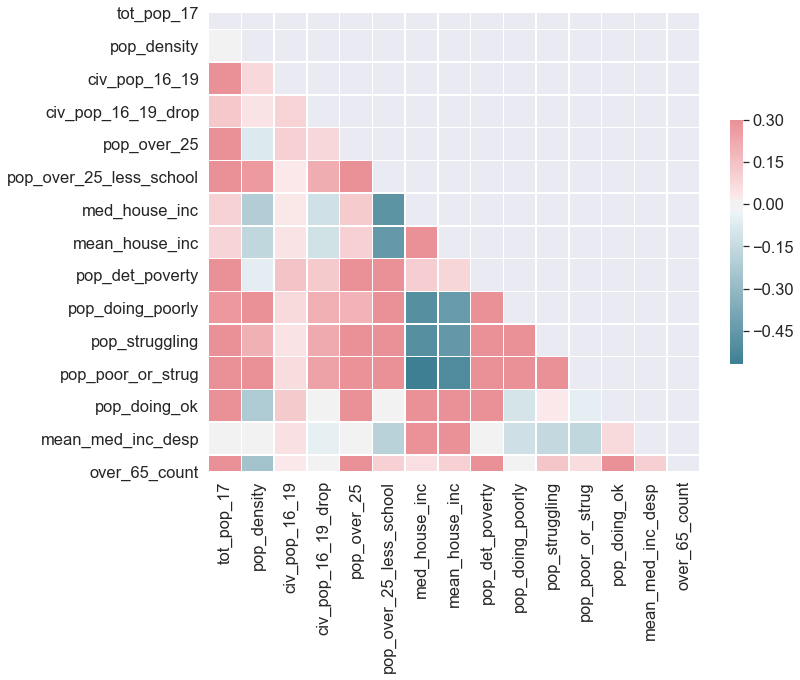

In [17]:
acs_sub_corr = acs_17_sub.drop('GEOID10', axis=1).corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(acs_sub_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(acs_sub_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
acs_17_sub.columns

Index(['GEOID10', 'tot_pop_17', 'pop_density', 'civ_pop_16_19',
       'civ_pop_16_19_drop', 'pop_over_25', 'pop_over_25_less_school',
       'med_house_inc', 'mean_house_inc', 'pop_det_poverty',
       'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug',
       'pop_doing_ok', 'mean_med_inc_desp', 'over_65_count'],
      dtype='object')

In [19]:
acs_17_sub.head()

,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,mean_med_inc_desp,over_65_count
0,250010101001,998,116.1545,8,0,894,46,52340.0,75538.664323,998,122,271,393,605,23198.664323,274
1,250010101002,314,613.6218,0,0,292,8,37841.0,65213.419913,314,55,36,91,223,27372.419913,193
2,250010101003,750,3997.7830,12,0,638,28,58098.0,84414.854111,741,59,81,140,601,26316.854111,297
3,250010101004,500,2019.0900,2,0,437,23,30396.0,46373.442623,500,46,206,252,248,15977.442623,202
4,250010101005,390,2952.7180,0,0,377,28,47895.0,66060.344828,390,32,59,91,299,18165.344828,92


In [20]:
print(acs_17_sub.columns)
print(town_block.columns)

Index(['GEOID10', 'tot_pop_17', 'pop_density', 'civ_pop_16_19',
       'civ_pop_16_19_drop', 'pop_over_25', 'pop_over_25_less_school',
       'med_house_inc', 'mean_house_inc', 'pop_det_poverty',
       'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug',
       'pop_doing_ok', 'mean_med_inc_desp', 'over_65_count'],
      dtype='object')
Index(['TOWN', 'POP2010', 'SHAPE_Area', 'GEOID10'], dtype='object')


In [21]:
town_block.columns = ['city_death', 'tot_pop_10', 'shape_area', 'GEOID10']
town_block.head()

,city_death,tot_pop_10,shape_area,GEOID10
0,wellesley,27982,2.726958e+07,2.502140e+11
1,wellesley,27982,2.726958e+07,2.502140e+11
2,wellesley,27982,2.726958e+07,2.502140e+11
3,wellesley,27982,2.726958e+07,2.502140e+11
4,wellesley,27982,2.726958e+07,2.502140e+11


In [22]:
town_acs_merge = town_block.merge(acs_17_sub, on='GEOID10', how='inner')

In [23]:
town_acs_merge.columns

Index(['city_death', 'tot_pop_10', 'shape_area', 'GEOID10', 'tot_pop_17',
       'pop_density', 'civ_pop_16_19', 'civ_pop_16_19_drop', 'pop_over_25',
       'pop_over_25_less_school', 'med_house_inc', 'mean_house_inc',
       'pop_det_poverty', 'pop_doing_poorly', 'pop_struggling',
       'pop_poor_or_strug', 'pop_doing_ok', 'mean_med_inc_desp',
       'over_65_count'],
      dtype='object')

In [24]:
town_acs_merge.head()

,city_death,tot_pop_10,shape_area,GEOID10,tot_pop_17,pop_density,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,med_house_inc,mean_house_inc,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,mean_med_inc_desp,over_65_count
0,wellesley,27982,2.726958e+07,2.502140e+11,1101,4438.051,96,0,636,0,183879.0,214803.395062,1101,0,0,0,1101,30924.395062,137
1,wellesley,27982,2.726958e+07,2.502140e+11,924,2064.697,108,0,634,0,250001.0,505804.304636,924,0,0,0,924,255803.304636,197
2,wellesley,27982,2.726958e+07,2.502140e+11,881,1947.536,9,0,552,11,181786.0,244652.447552,875,12,9,21,854,62866.447552,231
3,wellesley,27982,2.726958e+07,2.502140e+11,1177,2961.899,38,0,685,30,129071.0,240321.641791,1177,144,100,244,933,111250.641791,105
4,wellesley,27982,2.726958e+07,2.502140e+11,767,3843.039,10,0,590,22,86827.0,145115.151515,767,64,95,159,608,58288.151515,275


In [25]:
sum_stat_cols = [
    'city_death', 'tot_pop_17', 'over_65_count',
    'civ_pop_16_19', 'civ_pop_16_19_drop',
    'pop_over_25', 'pop_over_25_less_school',
    'pop_det_poverty', 'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug', 'pop_doing_ok'
]
town_17_pop = town_acs_merge.groupby('city_death').sum().reset_index()[sum_stat_cols]
town_17_pop.head()

,city_death,tot_pop_17,over_65_count,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok
0,abington,16275,2469,753,26,11377,615,16194,579,1626,2205,13989
1,acton,23455,4001,1476,18,16161,397,23307,893,973,1866,21441
2,acushnet,10443,2431,564,62,7635,1397,10336,422,1844,2266,8070
3,adams,8211,1764,333,23,6095,723,8209,910,1187,2097,6112
4,agawam,27769,6195,1177,0,20674,1602,26925,2553,3841,6394,20531


In [26]:
# get mean of other stats:
mean_stat_cols = ['city_death', 'tot_pop_10', 'shape_area', 'pop_density', 'med_house_inc', 'mean_house_inc', 'mean_med_inc_desp']
town_stats = town_acs_merge.groupby('city_death').mean().reset_index()[mean_stat_cols]
town_stats.head()

,city_death,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp
0,abington,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,11653.035505
1,acton,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,16789.737200
2,acushnet,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,10708.461556
3,adams,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12523.194660
4,agawam,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,13974.109446


In [27]:
town_merge = town_17_pop.merge(town_stats, on='city_death', how='inner')
print(town_merge.shape)
town_merge.head()

(347, 18)


,city_death,tot_pop_17,over_65_count,civ_pop_16_19,civ_pop_16_19_drop,pop_over_25,pop_over_25_less_school,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp
0,abington,16275,2469,753,26,11377,615,16194,579,1626,2205,13989,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,11653.035505
1,acton,23455,4001,1476,18,16161,397,23307,893,973,1866,21441,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,16789.737200
2,acushnet,10443,2431,564,62,7635,1397,10336,422,1844,2266,8070,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,10708.461556
3,adams,8211,1764,333,23,6095,723,8209,910,1187,2097,6112,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12523.194660
4,agawam,27769,6195,1177,0,20674,1602,26925,2553,3841,6394,20531,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,13974.109446


In [28]:
town_merge['drop_out'] = (town_merge['civ_pop_16_19_drop'] * 100) / town_merge['civ_pop_16_19']
town_merge['less_than_hs_ed'] = (town_merge['pop_over_25_less_school'] * 100) / town_merge['pop_over_25']
town_merge.drop(['pop_over_25', 'pop_over_25_less_school', 'civ_pop_16_19_drop', 'civ_pop_16_19'], axis = 1, inplace=True)
town_merge.head()

,city_death,tot_pop_17,over_65_count,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed
0,abington,16275,2469,16194,579,1626,2205,13989,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,11653.035505,3.452855,5.405643
1,acton,23455,4001,23307,893,973,1866,21441,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,16789.737200,1.219512,2.456531
2,acushnet,10443,2431,10336,422,1844,2266,8070,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,10708.461556,10.992908,18.297315
3,adams,8211,1764,8209,910,1187,2097,6112,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12523.194660,6.906907,11.862182
4,agawam,27769,6195,26925,2553,3841,6394,20531,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,13974.109446,0.000000,7.748863


In [29]:
# before calculated dropout by block - had many zeroes - is this alterntive method more informative?
town_merge[['drop_out', 'less_than_hs_ed']].describe()

,drop_out,less_than_hs_ed
count,346.000000,347.000000
mean,2.355802,6.544580
std,4.012968,4.750990
min,0.000000,0.000000
25%,0.000000,3.235427
50%,0.318954,5.405643
75%,3.184586,8.318470
max,30.000000,32.336132


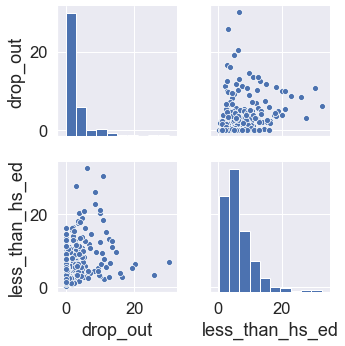

In [30]:
sns.pairplot(town_merge[['drop_out', 'less_than_hs_ed']].dropna())

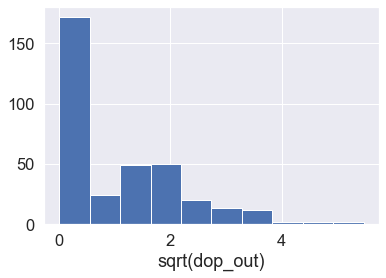

In [31]:
np.sqrt(town_merge['drop_out']).hist(bins=10)
plt.xlabel('sqrt(dop_out)')
plt.show()

In [32]:
town_merge.head()

,city_death,tot_pop_17,over_65_count,pop_det_poverty,pop_doing_poorly,pop_struggling,pop_poor_or_strug,pop_doing_ok,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed
0,abington,16275,2469,16194,579,1626,2205,13989,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,11653.035505,3.452855,5.405643
1,acton,23455,4001,23307,893,973,1866,21441,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,16789.737200,1.219512,2.456531
2,acushnet,10443,2431,10336,422,1844,2266,8070,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,10708.461556,10.992908,18.297315
3,adams,8211,1764,8209,910,1187,2097,6112,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12523.194660,6.906907,11.862182
4,agawam,27769,6195,26925,2553,3841,6394,20531,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,13974.109446,0.000000,7.748863


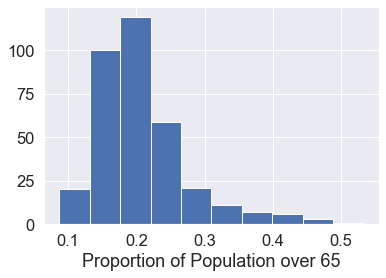

In [34]:
town_merge['over_65_prop'] = town_merge['over_65_count'] / town_merge['tot_pop_17']
town_merge['over_65_prop'].hist()
plt.xlabel('Proportion of Population over 65')
plt.show()

      B13004_001:     Population for Whom Poverty Status Is Determined:
      B13004_002:     Population for Whom Poverty Status Is Determined: Under 1.00 (Doing Poorly)
      B13004_003:     Population for Whom Poverty Status Is Determined: 1.00 to 1.99 (Struggling)
      B13004_004:     Population for Whom Poverty Status Is Determined: Under 2.00 (Poor or Struggling)
      B13004_005:     Population for Whom Poverty Status Is Determined: 2.00 and Over (Doing Ok)

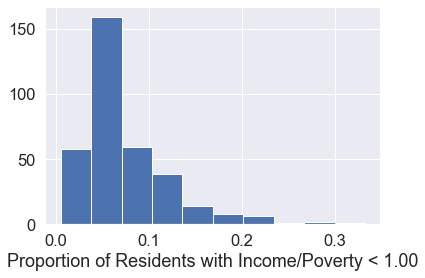

In [43]:
# poverty calc
town_merge.head()
town_merge['at_or_below_pov_prop'] = town_merge['pop_doing_poorly'] / town_merge['pop_det_poverty']
town_merge['at_or_below_pov_prop'].hist(bins=10)
plt.xlabel('Proportion of Residents with Income/Poverty < 1.00')
plt.show()

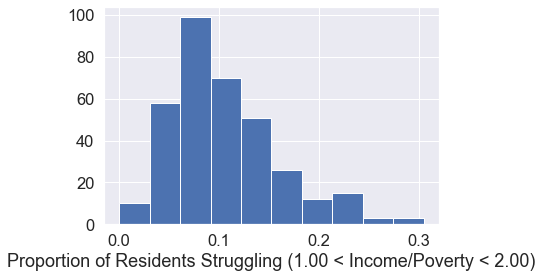

In [47]:
town_merge['pop_struggling_prop'] = town_merge['pop_struggling'] / town_merge['pop_det_poverty']
town_merge['pop_struggling_prop'].hist(bins=10)
plt.xlabel('Proportion of Residents Struggling (1.00 < Income/Poverty < 2.00)')
plt.show()

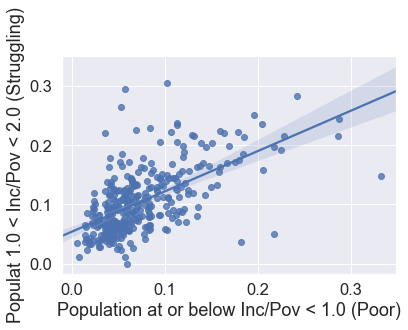

In [50]:
sns.regplot(x='at_or_below_pov_prop', y='pop_struggling_prop', data=town_merge)
plt.xlabel('Population at or below Inc/Pov < 1.0 (Poor)')
plt.ylabel('Populat 1.0 < Inc/Pov < 2.0 (Struggling)')
plt.show()

In [52]:
town_merge.drop(['pop_det_poverty', 'pop_doing_poorly', 'pop_struggling', 'pop_poor_or_strug', 'pop_doing_ok'], axis=1, inplace=True)
town_merge.head()

,city_death,tot_pop_17,over_65_count,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed,over_65_prop,at_or_below_pov_prop,pop_struggling_prop
0,abington,16275,2469,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,11653.035505,3.452855,5.405643,0.151705,0.035754,0.100408
1,acton,23455,4001,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,16789.737200,1.219512,2.456531,0.170582,0.038315,0.041747
2,acushnet,10443,2431,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,10708.461556,10.992908,18.297315,0.232788,0.040828,0.178406
3,adams,8211,1764,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12523.194660,6.906907,11.862182,0.214834,0.110854,0.144597
4,agawam,27769,6195,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,13974.109446,0.000000,7.748863,0.223090,0.094819,0.142656


In [54]:
town_merge.describe()

,tot_pop_17,over_65_count,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed,over_65_prop,at_or_below_pov_prop,pop_struggling_prop
count,347.000000,347.000000,347.000000,3.470000e+02,347.000000,346.000000,347.000000,346.000000,346.000000,347.000000,347.000000,347.000000,347.000000
mean,19490.746398,3434.824207,18858.389049,5.969708e+07,2292.685930,88305.727278,109444.035932,21079.291563,2.355802,6.544580,0.207933,0.073728,0.104279
std,41540.511381,5642.967441,39009.479522,3.390152e+07,4049.633320,29088.836206,39888.981321,15309.458177,4.012968,4.750990,0.068754,0.047828,0.054009
min,34.000000,15.000000,75.000000,3.249309e+06,2.578370,38909.750000,50750.537570,2129.112803,0.000000,0.000000,0.086886,0.005354,0.000000
25%,4196.000000,781.000000,4008.000000,3.731440e+07,285.202885,68215.428571,82839.316239,12204.613762,0.000000,3.235427,0.166202,0.042404,0.064869
50%,10560.000000,1977.000000,10300.000000,5.455734e+07,933.183133,83124.625000,100209.367399,16659.458813,0.318954,5.405643,0.193279,0.059730,0.092496
75%,22704.000000,4385.000000,21691.500000,7.446341e+07,2452.889962,102446.289216,126078.167762,24196.761231,3.184586,8.318470,0.230995,0.092880,0.132362
max,668541.000000,85040.000000,617594.000000,2.661817e+08,30236.970333,203026.750000,316351.858774,113325.108774,30.000000,32.336132,0.532847,0.332260,0.304869


In [53]:
# combine town info + opioid overdose death count data
full_merge = town_merge.merge(death_data, on='city_death', how='inner')
print(full_merge.shape)
full_merge.head()

(347, 21)


,city_death,tot_pop_17,over_65_count,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,...,over_65_prop,at_or_below_pov_prop,pop_struggling_prop,2012,2013,2014,2015,2016,2017,2018
0,abington,16275,2469,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,11653.035505,3.452855,...,0.151705,0.035754,0.100408,1,2,0,6,1,3,5
1,acton,23455,4001,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,16789.737200,1.219512,...,0.170582,0.038315,0.041747,2,0,1,2,3,0,1
2,acushnet,10443,2431,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,10708.461556,10.992908,...,0.232788,0.040828,0.178406,2,0,0,4,2,4,0
3,adams,8211,1764,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12523.194660,6.906907,...,0.214834,0.110854,0.144597,1,1,2,3,1,0,4
4,agawam,27769,6195,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,13974.109446,0.000000,...,0.223090,0.094819,0.142656,1,3,1,2,0,4,8


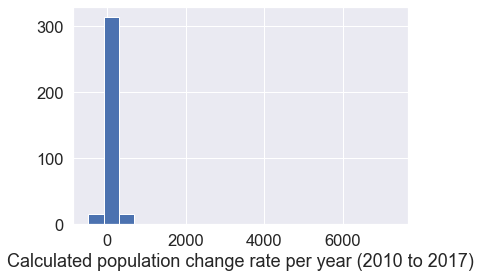

In [123]:
full_merge['pop_change_rate'] = (full_merge['tot_pop_17'] - full_merge['tot_pop_10']) / (2017 - 2010)
full_merge['pop_change_rate'].hist(bins=20)
plt.xlabel('Calculated population change rate per year (2010 to 2017)')
plt.show()

In [124]:
full_merge[full_merge['pop_change_rate'] > 1000]

,city_death,tot_pop_17,over_65_count,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,...,tot_pop_18,death_rate_12,death_rate_13,death_rate_14,death_rate_15,death_rate_16,death_rate_17,death_rate_18,town_status,urb_v_rur
35,boston,668541,85040,617594.0,1.295200e+08,27786.891612,71196.049505,92167.940523,22125.401865,2.033172,...,675819.142857,0.980779,1.266756,2.582315,3.455738,3.916748,4.173267,3.62523,grown,urban


In [ ]:
full_merge['tot_pop_16'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate']
full_merge['tot_pop_15'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 2
full_merge['tot_pop_14'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 3
full_merge['tot_pop_13'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 4
full_merge['tot_pop_12'] = full_merge['tot_pop_17'] - full_merge['pop_change_rate'] * 5
full_merge['tot_pop_18'] = full_merge['tot_pop_17'] + full_merge['pop_change_rate']
full_merge.head()

In [57]:
# calculate opioid overdose death rate per 10k residents (so that numbers aren't just small decimals)
full_merge['death_rate_12'] = (full_merge['2012'] / full_merge['tot_pop_12']) * 10000
full_merge['death_rate_13'] = (full_merge['2013'] / full_merge['tot_pop_13']) * 10000
full_merge['death_rate_14'] = (full_merge['2014'] / full_merge['tot_pop_14']) * 10000
full_merge['death_rate_15'] = (full_merge['2015'] / full_merge['tot_pop_15']) * 10000
full_merge['death_rate_16'] = (full_merge['2016'] / full_merge['tot_pop_16']) * 10000
full_merge['death_rate_17'] = (full_merge['2017'] / full_merge['tot_pop_17']) * 10000
full_merge['death_rate_18'] = (full_merge['2018'] / full_merge['tot_pop_18']) * 10000
full_merge.head()

,city_death,tot_pop_17,over_65_count,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,...,tot_pop_13,tot_pop_12,tot_pop_18,death_rate_12,death_rate_13,death_rate_14,death_rate_15,death_rate_16,death_rate_17,death_rate_18
0,abington,16275,2469,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,11653.035505,3.452855,...,16109.285714,16067.857143,16316.428571,0.622361,1.241520,0.000000,3.705501,0.616007,1.843318,3.064396
1,acton,23455,4001,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,16789.737200,1.219512,...,22580.142857,22361.428571,23673.714286,0.894397,0.000000,0.438618,0.868901,1.291084,0.000000,0.422409
2,acushnet,10443,2431,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,10708.461556,10.992908,...,10363.000000,10343.000000,10463.000000,1.933675,0.000000,0.000000,3.845045,1.918833,3.830317,0.000000
3,adams,8211,1764,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12523.194660,6.906907,...,8367.571429,8406.714286,8171.857143,1.189525,1.195090,2.401413,3.619130,1.212100,0.000000,4.894848
4,agawam,27769,6195,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,13974.109446,0.000000,...,28151.285714,28246.857143,27673.428571,0.354022,1.065671,0.356434,0.715304,0.000000,1.440455,2.890860


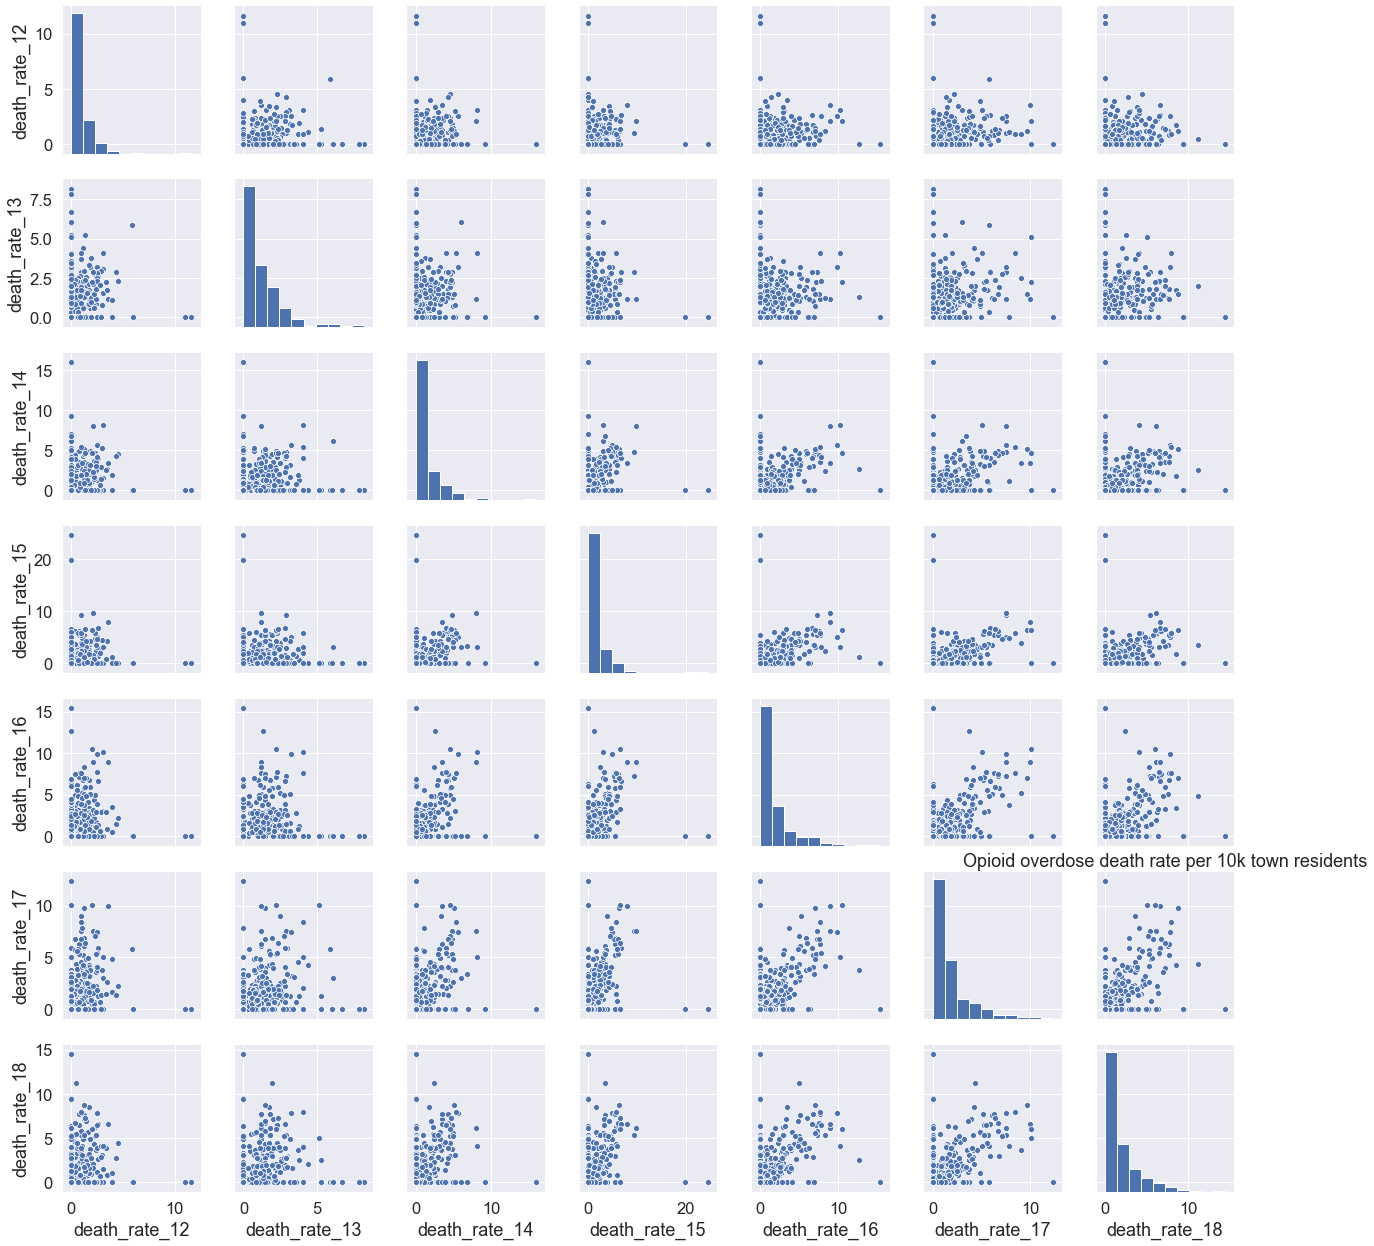

In [67]:
sns.pairplot(full_merge.iloc[:, 28:35])
plt.title('Opioid overdose death rate per 10k town residents')
plt.show()

In [70]:
full_merge['town_status'] = ['grown' if x > 0 else 'shrunk' for x in full_merge['pop_change_rate']]
full_merge['town_status'].value_counts()

grown     274
shrunk     73
Name: town_status, dtype: int64

In [92]:
full_merge['urb_v_rur'] = ['urban' if x >= 50000 else 'rural' for x in full_merge['tot_pop_17']]
full_merge['urb_v_rur'].value_counts()

rural    322
urban     25
Name: urb_v_rur, dtype: int64

In [93]:
full_merge.columns

Index(['city_death', 'tot_pop_17', 'over_65_count', 'tot_pop_10', 'shape_area',
       'pop_density', 'med_house_inc', 'mean_house_inc', 'mean_med_inc_desp',
       'drop_out', 'less_than_hs_ed', 'over_65_prop', 'at_or_below_pov_prop',
       'pop_struggling_prop', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', 'pop_change_rate', 'tot_pop_16', 'tot_pop_15', 'tot_pop_14',
       'tot_pop_13', 'tot_pop_12', 'tot_pop_18', 'death_rate_12',
       'death_rate_13', 'death_rate_14', 'death_rate_15', 'death_rate_16',
       'death_rate_17', 'death_rate_18', 'town_status', 'urb_v_rur'],
      dtype='object')

In [113]:
full_merge_17 = full_merge.iloc[:, np.r_[0:2, 5:14, 21, 33:37]].copy()
full_merge_17.head()

,city_death,tot_pop_17,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed,over_65_prop,at_or_below_pov_prop,pop_struggling_prop,pop_change_rate,death_rate_17,death_rate_18,town_status,urb_v_rur
0,abington,16275,1932.969130,87156.000000,98809.035505,11653.035505,3.452855,5.405643,0.151705,0.035754,0.100408,41.428571,1.843318,3.064396,grown,rural
1,acton,23455,1257.583593,139890.466667,156680.203867,16789.737200,1.219512,2.456531,0.170582,0.038315,0.041747,218.714286,0.000000,0.422409,grown,rural
2,acushnet,10443,1152.357871,69624.714286,80333.175842,10708.461556,10.992908,18.297315,0.232788,0.040828,0.178406,20.000000,3.830317,0.000000,grown,rural
3,adams,8211,1982.318840,48445.400000,60968.594660,12523.194660,6.906907,11.862182,0.214834,0.110854,0.144597,-39.142857,0.000000,4.894848,shrunk,rural
4,agawam,27769,1897.273569,65490.125000,79464.234446,13974.109446,0.000000,7.748863,0.223090,0.094819,0.142656,-95.571429,1.440455,2.890860,shrunk,rural


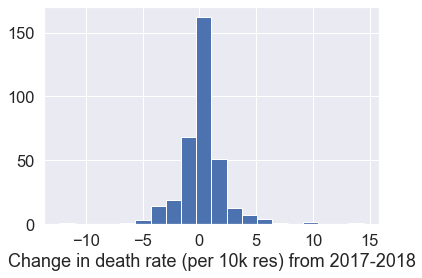

In [114]:
full_merge_17['rate_chng_17_to_18'] = full_merge_17['death_rate_18'] - full_merge_17['death_rate_17']
full_merge_17['rate_chng_17_to_18'].hist(bins=20)
plt.xlabel('Change in death rate (per 10k res) from 2017-2018')
plt.show()

In [115]:
full_merge_17.describe()

,tot_pop_17,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed,over_65_prop,at_or_below_pov_prop,pop_struggling_prop,pop_change_rate,death_rate_17,death_rate_18,rate_chng_17_to_18
count,347.000000,347.000000,346.000000,347.000000,346.000000,346.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,19490.746398,2292.685930,88305.727278,109444.035932,21079.291563,2.355802,6.544580,0.207933,0.073728,0.104279,90.336764,1.627136,1.766947,0.139812
std,41540.511381,4049.633320,29088.836206,39888.981321,15309.458177,4.012968,4.750990,0.068754,0.047828,0.054009,408.250591,2.148897,2.270682,2.109397
min,34.000000,2.578370,38909.750000,50750.537570,2129.112803,0.000000,0.000000,0.086886,0.005354,0.000000,-472.714286,0.000000,0.000000,-12.330456
25%,4196.000000,285.202885,68215.428571,82839.316239,12204.613762,0.000000,3.235427,0.166202,0.042404,0.064869,4.428571,0.000000,0.000000,-0.618454
50%,10560.000000,933.183133,83124.625000,100209.367399,16659.458813,0.318954,5.405643,0.193279,0.059730,0.092496,37.571429,0.964227,1.073858,0.000000
75%,22704.000000,2452.889962,102446.289216,126078.167762,24196.761231,3.184586,8.318470,0.230995,0.092880,0.132362,109.214286,2.248725,2.531146,0.848789
max,668541.000000,30236.970333,203026.750000,316351.858774,113325.108774,30.000000,32.336132,0.532847,0.332260,0.304869,7278.142857,12.330456,14.453851,14.453851


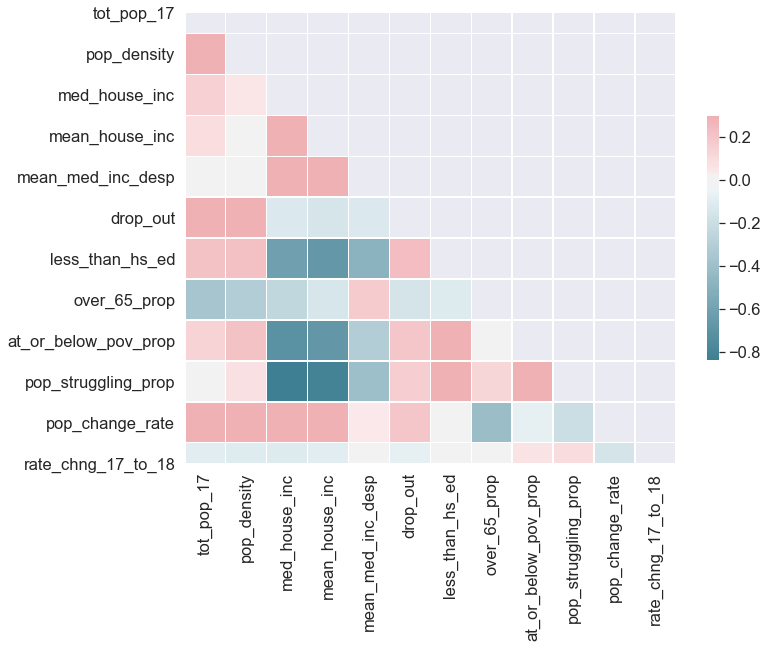

In [116]:
full_merge_17_corr = full_merge_17.drop(['city_death', 'death_rate_17', 'death_rate_18'], axis=1).dropna().corr(method='spearman')
mask = np.zeros_like(full_merge_17_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(full_merge_17_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

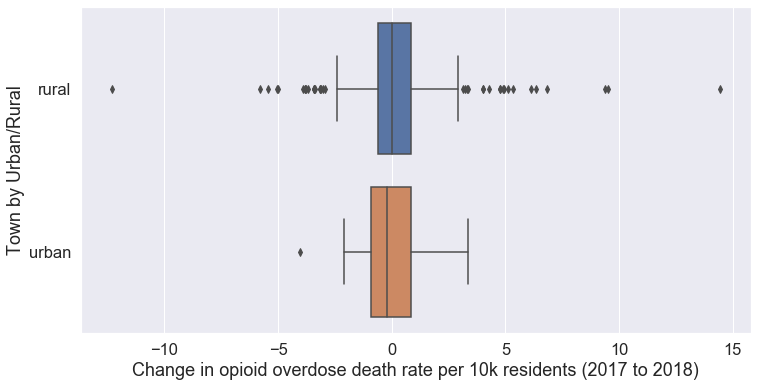

In [117]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='urb_v_rur', x='rate_chng_17_to_18', orient='h', data=full_merge_17)
plt.ylabel('Town by Urban/Rural')
plt.xlabel('Change in opioid overdose death rate per 10k residents (2017 to 2018)')
plt.show()

In [118]:
# mean rate of change:
print(full_merge_17['rate_chng_17_to_18'].mean())
# sem of the change in rate:
print(full_merge_17[['rate_chng_17_to_18']].sem(axis=0))
full_merge_17[['urb_v_rur', 'rate_chng_17_to_18']].groupby('urb_v_rur').mean()

0.1398118818327503
rate_chng_17_to_18    0.113238
dtype: float64


,rate_chng_17_to_18
urb_v_rur,
rural,0.161618
urban,-0.141045


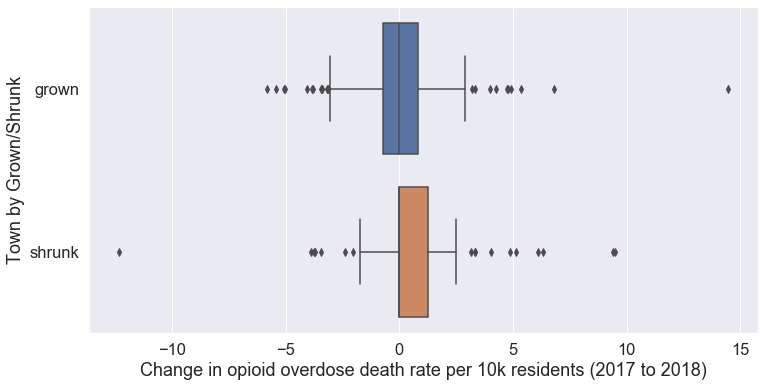

In [119]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='town_status', x='rate_chng_17_to_18', orient='h', data=full_merge_17)
plt.ylabel('Town by Grown/Shrunk')
plt.xlabel('Change in opioid overdose death rate per 10k residents (2017 to 2018)')
plt.show()

In [120]:
full_merge_17[['town_status', 'rate_chng_17_to_18']].groupby('town_status').mean()

,rate_chng_17_to_18
town_status,
grown,0.063617
shrunk,0.425805


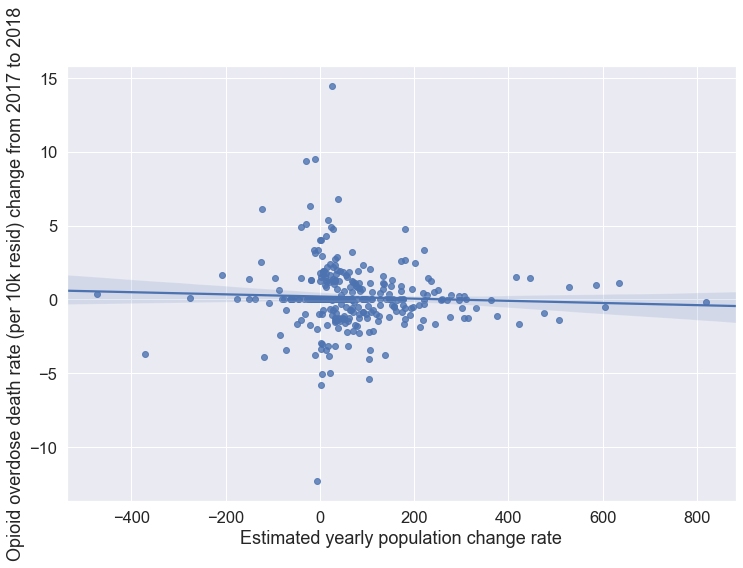

In [126]:
plt.figure(figsize=(12, 8))
sns.regplot(x='pop_change_rate', y='rate_chng_17_to_18', data=full_merge_17[full_merge_17['pop_change_rate'] < 1000])
plt.xlabel('Estimated yearly population change rate')
plt.ylabel('Opioid overdose death rate (per 10k resid) change from 2017 to 2018')
plt.show()

Think the estimated population change will probably not be useful, also most likely these two variables are confounded because population estimates for each year were calculated using the population change rate.

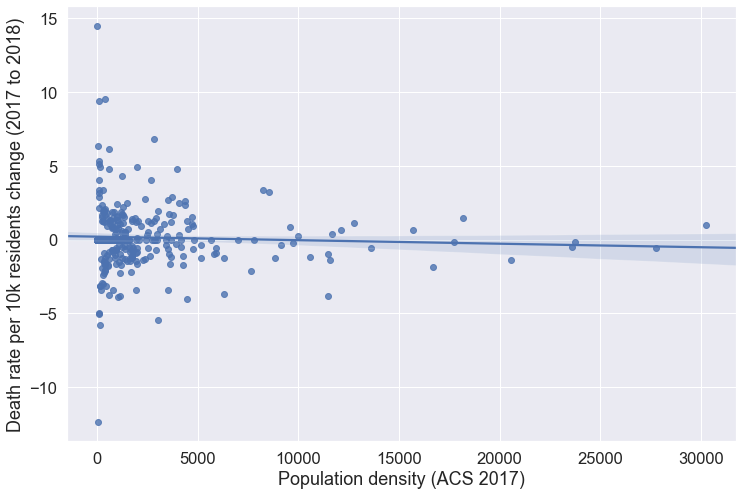

In [127]:
plt.figure(figsize=(12, 8))
sns.regplot(x='pop_density', y='rate_chng_17_to_18', data=full_merge_17)
plt.xlabel('Population density (ACS 2017)')
plt.ylabel('Death rate per 10k residents change (2017 to 2018)')
plt.show()

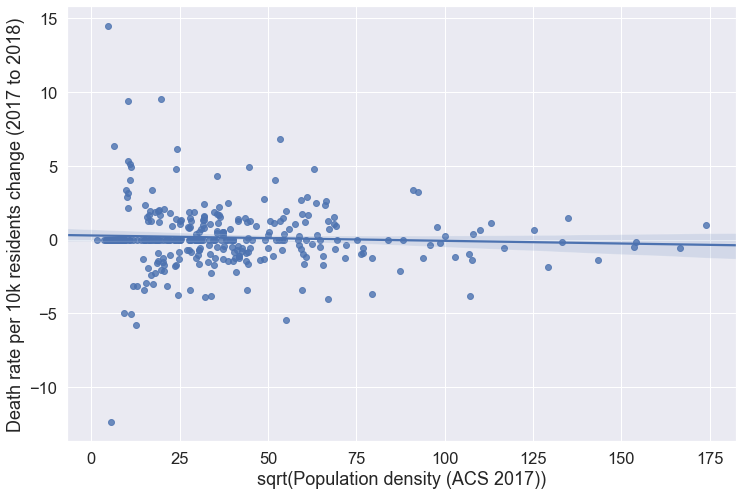

In [128]:
full_merge_17['pop_den_sqrt'] = np.sqrt(full_merge_17['pop_density'])
plt.figure(figsize=(12, 8))
sns.regplot(x='pop_den_sqrt', y='rate_chng_17_to_18', data=full_merge_17)
plt.xlabel('sqrt(Population density (ACS 2017))')
plt.ylabel('Death rate per 10k residents change (2017 to 2018)')
plt.show()

In [130]:
full_merge.head()

,city_death,tot_pop_17,over_65_count,tot_pop_10,shape_area,pop_density,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,...,tot_pop_18,death_rate_12,death_rate_13,death_rate_14,death_rate_15,death_rate_16,death_rate_17,death_rate_18,town_status,urb_v_rur
0,abington,16275,2469,15985.0,2.639085e+07,1932.969130,87156.000000,98809.035505,11653.035505,3.452855,...,16316.428571,0.622361,1.241520,0.000000,3.705501,0.616007,1.843318,3.064396,grown,rural
1,acton,23455,4001,21924.0,5.256453e+07,1257.583593,139890.466667,156680.203867,16789.737200,1.219512,...,23673.714286,0.894397,0.000000,0.438618,0.868901,1.291084,0.000000,0.422409,grown,rural
2,acushnet,10443,2431,10303.0,4.889337e+07,1152.357871,69624.714286,80333.175842,10708.461556,10.992908,...,10463.000000,1.933675,0.000000,0.000000,3.845045,1.918833,3.830317,0.000000,grown,rural
3,adams,8211,1764,8485.0,5.946649e+07,1982.318840,48445.400000,60968.594660,12523.194660,6.906907,...,8171.857143,1.189525,1.195090,2.401413,3.619130,1.212100,0.000000,4.894848,shrunk,rural
4,agawam,27769,6195,28438.0,6.302191e+07,1897.273569,65490.125000,79464.234446,13974.109446,0.000000,...,27673.428571,0.354022,1.065671,0.356434,0.715304,0.000000,1.440455,2.890860,shrunk,rural


In [131]:
full_merge.columns

Index(['city_death', 'tot_pop_17', 'over_65_count', 'tot_pop_10', 'shape_area',
       'pop_density', 'med_house_inc', 'mean_house_inc', 'mean_med_inc_desp',
       'drop_out', 'less_than_hs_ed', 'over_65_prop', 'at_or_below_pov_prop',
       'pop_struggling_prop', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', 'pop_change_rate', 'tot_pop_16', 'tot_pop_15', 'tot_pop_14',
       'tot_pop_13', 'tot_pop_12', 'tot_pop_18', 'death_rate_12',
       'death_rate_13', 'death_rate_14', 'death_rate_15', 'death_rate_16',
       'death_rate_17', 'death_rate_18', 'town_status', 'urb_v_rur'],
      dtype='object')

In [146]:
full_merge_cols = list(full_merge.columns)
full_merge_select = full_merge_cols[:3] + full_merge_cols[11:12] + full_merge_cols[6:11] + full_merge_cols[12:14] + full_merge_cols[35:] + full_merge_cols[28:35]
print(full_merge_select)
full_merge_for_csv = full_merge[full_merge_select].copy()
full_merge_for_csv.head()

['city_death', 'tot_pop_17', 'over_65_count', 'over_65_prop', 'med_house_inc', 'mean_house_inc', 'mean_med_inc_desp', 'drop_out', 'less_than_hs_ed', 'at_or_below_pov_prop', 'pop_struggling_prop', 'town_status', 'urb_v_rur', 'death_rate_12', 'death_rate_13', 'death_rate_14', 'death_rate_15', 'death_rate_16', 'death_rate_17', 'death_rate_18']


,city_death,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,mean_med_inc_desp,drop_out,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,town_status,urb_v_rur,death_rate_12,death_rate_13,death_rate_14,death_rate_15,death_rate_16,death_rate_17,death_rate_18
0,abington,16275,2469,0.151705,87156.000000,98809.035505,11653.035505,3.452855,5.405643,0.035754,0.100408,grown,rural,0.622361,1.241520,0.000000,3.705501,0.616007,1.843318,3.064396
1,acton,23455,4001,0.170582,139890.466667,156680.203867,16789.737200,1.219512,2.456531,0.038315,0.041747,grown,rural,0.894397,0.000000,0.438618,0.868901,1.291084,0.000000,0.422409
2,acushnet,10443,2431,0.232788,69624.714286,80333.175842,10708.461556,10.992908,18.297315,0.040828,0.178406,grown,rural,1.933675,0.000000,0.000000,3.845045,1.918833,3.830317,0.000000
3,adams,8211,1764,0.214834,48445.400000,60968.594660,12523.194660,6.906907,11.862182,0.110854,0.144597,shrunk,rural,1.189525,1.195090,2.401413,3.619130,1.212100,0.000000,4.894848
4,agawam,27769,6195,0.223090,65490.125000,79464.234446,13974.109446,0.000000,7.748863,0.094819,0.142656,shrunk,rural,0.354022,1.065671,0.356434,0.715304,0.000000,1.440455,2.890860


In [148]:
#full_merge_for_csv.to_csv("../../data/tidy_data/death_count_norm_to_pop_and_acs_town_demographics_merge.csv", index=False)